In [1]:
print('Hello Word')

Hello Word


In [2]:
### import os
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from Cleaning import GetCleanedData
import pandas as pd
import matplotlib.pyplot as plt

# Chemin du fichier TAR
PATH = 'src'
tar_path = PATH +'/corenlp_plot_summaries.tar'

# Fonction pour extraire le texte nettoyé de chaque fichier XML
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        # Parcourir chaque token dans le XML (ajustez si la structure XML diffère)
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            # Garder uniquement les lemmes de certains types de mots
            if pos in {'NN', 'VB', 'JJ'}:  # Noms, verbes, adjectifs
                filtered_words.append(lemma)
                
        return ' '.join(filtered_words)

# Liste pour stocker tous les documents traités
documents = []
ids = []

# Ouverture et traitement du fichier TAR
with tarfile.open(tar_path, 'r') as tar:
    # Parcourir chaque fichier dans le fichier TAR
    for member in tar.getmembers():
        # Vérifier si c'est un fichier XML compressé (.xml.gz)
        if member.name.endswith('.xml.gz'):
            # Extraire le fichier .xml.gz dans un fichier temporaire
            with tar.extractfile(member) as xml_gz_file:
                # Analyser le fichier XML pour obtenir le texte nettoyé
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

In [3]:
# Vectorisation avec CountVectorizer pour LDA
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)
# Application de LDA
lda = LatentDirichletAllocation(n_components=6)
lda.fit(doc_term_matrix)

# Extraction des termes pour chaque sujet
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]  # Top 10 termes pour chaque sujet
    print(f"Topic {index}: {top_terms}")

Topic 0: ['way', 'time', 'gun', 'night', 'money', 'room', 'house', 'man', 'police', 'car']
Topic 1: ['magic', 'film', 'witch', 'story', 'tree', 'book', 'http', 'www', 'com', 'dog']
Topic 2: ['daughter', 'son', 'young', 'man', 'wife', 'film', 'father', 'life', 'family', 'love']
Topic 3: ['old', 'town', 'time', 'day', 'night', 'house', 'home', 'father', 'school', 'mother']
Topic 4: ['island', 'time', 'life', 'fight', 'help', 'escape', 'death', 'kill', 'man', 'ship']
Topic 5: ['game', 'german', 'world', 'new', 'group', 'time', 'american', 'war', 'team', 'film']


In [4]:
# Transformation des documents en probabilités de thème
doc_topic_dist = lda.transform(doc_term_matrix)

# Pour chaque document, trouver les 3 thèmes les plus présents avec leur proportion
top_themes_per_document = []
for i, doc in enumerate(doc_topic_dist):
    # Obtenir les indices des 3 thèmes les plus probables:
    top_indices = doc.argsort()[-3:][::-1]
    # Obtenir les proportions pour ces thèmes:
    top_proportions = doc[top_indices]

    # Ajouter les informations dans une structure de données par film
    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],  # Identifiant du film
        "Thème 1": top_indices[0],
        "Prop Thème 1": top_proportions[0],
        "Thème 2": top_indices[1],
        "Prop Thème 2": top_proportions[1],
        "Thème 3": top_indices[2],
        "Prop Thème 3": top_proportions[2]
    })

# Convertir en DataFrame pour une meilleure visualisation
df_top_themes = pd.DataFrame(top_themes_per_document)
df_top_themes.head()

,Wikipedia movie ID,Thème 1,Prop Thème 1,Thème 2,Prop Thème 2,Thème 3,Prop Thème 3
0,31954962,0,0.361393,1,0.324745,4,0.297610
1,32984773,4,0.443307,3,0.197745,0,0.196512
2,706861,0,0.432166,4,0.240758,5,0.172134
3,15789864,4,0.683642,2,0.230642,1,0.074721
4,34528861,2,0.662414,0,0.331421,5,0.001545


In [5]:
df1, df2,df3 = GetCleanedData()
df1.head()

C:\Users\romai\OneDrive\EPFL\MA1\Applied_Data_Analysis\ada-2024-project-4bigbrains\Cleaning.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_revenue_clean['Movie release date'] = df_date_revenue_clean['Movie release date'].apply(format_date)
C:\Users\romai\OneDrive\EPFL\MA1\Applied_Data_Analysis\ada-2024-project-4bigbrains\Cleaning.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_clean['Movie release date'] = df_date_clean['Movie release date'].apply(format_date)
C:\Users\romai\OneDr

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,[Drama]


In [6]:
df1['Wikipedia movie ID'] = df1['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)

merged_df = pd.merge(df1, df_top_themes, on='Wikipedia movie ID', how='inner')

In [7]:
merged_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Thème 1,Prop Thème 1,Thème 2,Prop Thème 2,Thème 3,Prop Thème 3
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",5,0.628297,4,0.239456,0,0.085611
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",0,0.485935,4,0.231338,2,0.175484
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,[Drama],2,0.668328,0,0.324293,3,0.001851
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],South Africa,"[Family Film, Fantasy, Adventure, World cinema]",4,0.644927,1,0.339386,3,0.003934
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],United States of America,"[Romantic comedy, Ensemble Film, Comedy-drama,...",2,0.881629,3,0.102024,0,0.004105


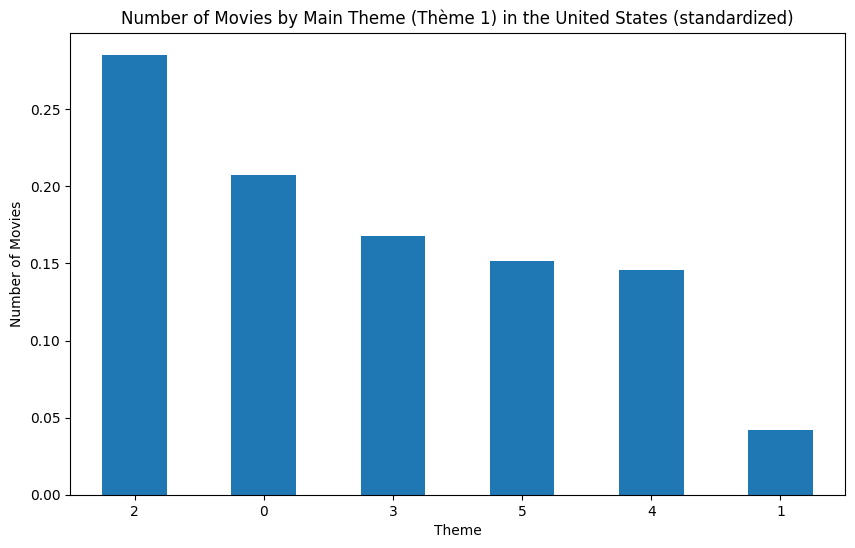

In [8]:
# Filter the DataFrame for movies from the United States
us_movies = merged_df[merged_df['Movie country'] == 'United States of America']

# Count the occurrences of each theme in "Thème 1" for US movies
theme_counts_us = us_movies['Thème 1'].value_counts()
theme_counts_us_stand = theme_counts_us/theme_counts_us.sum()
# Plot the histogram of theme counts
theme_counts_us_stand.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Movies by Main Theme (Thème 1) in the United States (standardized)")
plt.xlabel("Theme")
plt.ylabel("Number of Movies")
plt.xticks(rotation=0)
plt.show()

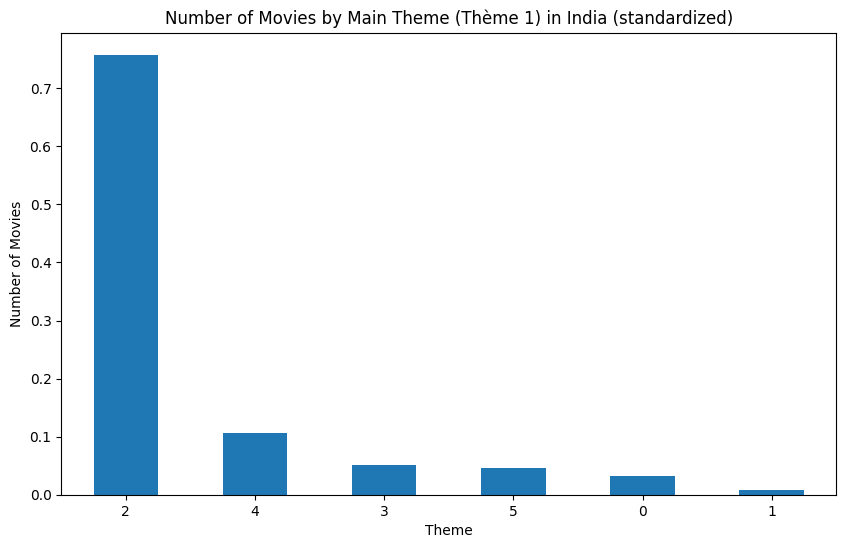

In [9]:
# Filter the DataFrame for movies from India
indian_movies = merged_df[merged_df['Movie country'] == 'India']

# Count the occurrences of each theme in "Thème 1" for indian movies
theme_counts_indian = indian_movies['Thème 1'].value_counts()
theme_counts_indian_stand = theme_counts_indian/theme_counts_indian.sum()
# Plot the histogram of theme counts
theme_counts_indian_stand.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Movies by Main Theme (Thème 1) in India (standardized)")
plt.xlabel("Theme")
plt.ylabel("Number of Movies")
plt.xticks(rotation=0)
plt.show()